In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import minmax_scale
import os


In [2]:
# carga de datos de refencia en un data frame para su filtrado
path = 'reference_data/'
files = os.listdir(path)

dict_files = {
    'date':list(),
    'link':list()
}

for file in files:
    if '.nc' in file:
        # generacion link
        link = os.path.join(
            path,
            file
        )
        #Formateo fecha
        year = file.split('_')[2]
        month = file.split('_')[3].split('.')[0]
        date = pd.to_datetime(year + '/' + month)
        # Almacenamiento
        dict_files['date'].append(date)
        dict_files['link'].append(link)
# Creacion del dataframe
df_files_reference = pd.DataFrame(dict_files)
df_files_reference.set_index(
    'date',
    drop=True,
    inplace=True
)
df_files_reference_reference = df_files_reference.sort_index()

In [3]:
# carga de datos target para su filtrado
path = 'target_data/'
files_target = os.listdir(path)
files_target = [path+file_name for file_name in files_target]

In [4]:
def get_data_by_coordenates_date_ERA(lat,long,start,end,height):
    """
    se tienen los datos de reanalisis de ERA,
    lo que se hace aquí es filtrar del data frame df_files_reference
    la locacion, temporalidad y altura de todos los datos disponibles
    
    """
    start = str(start)
    end = str(end)
    height = str(height)

    # se entregan los datos de fecha con el formato "1990-01-30"
    mask = (df_files_reference.index>=start) & (df_files_reference.index<end)
    df_filtered = df_files_reference[mask]
    
    acum = xr.open_dataset(df_filtered['link'].iloc[0]).sel(
            latitude = lat,
            longitude = long,
            method = 'nearest'

    )
    for link in df_filtered[(df_filtered.index>=start) & (df_filtered.index<end)]['link'][1:].to_numpy():
        # print(f'processing {link}')
        temporal = xr.open_dataset(link).sel(
            latitude= lat,
            longitude = long,
            method = 'nearest'

        )
        acum = xr.concat([acum,temporal],dim = "valid_time")
        
    df = acum.to_dataframe()
    if height == '10':
        df = np.hypot(df['u10'],df['v10'])
    elif height == '100':
        df = np.hypot(df['u100'],df['v100'])
    else:
        raise Exception('Not a valid height, type "10" or "100"')
    
    df.columns = ['wind_speed (m/s)']

    return pd.DataFrame(df).sort_index()


# conseguir datos de la carpeta de estaciones velocidad del viendo ideam
def get_data_by_coordenates_date_ideam(station,start,end):
    # se entregan los datos de fecha con el formato "1990-01-30"
    """
    se usa el file_target como el arreglo donde están los archivos disponibles para el analisis de datos
    se retorna un data frame de pandas con la información de velocidad de viento de ideam en la 
    estacion y años indicados
    """
    start = str(start)
    end = str(end)
    file_path = None
    for files_target_path in files_target:
        if station in files_target_path:
            file_path = files_target_path
            break

    if file_path == None:
        raise Exception('Información de estación no disponible')
    df = pd.read_csv(file_path,sep = '\t')
    df = df.set_index('fecha')
    df.index = pd.to_datetime(df.index)
    
    # return df[(df.index>=start)&(df.index<end)].sort_index().resample('h').mean()
    return df[(df.index>=start)&(df.index<end)].sort_index()




<h3>Desde aquí se inicia el análisis de los datos, el código anterior son funciones de apoyo</h3>

In [5]:
# retrieving reference data
station = '0015075501'
lat = 	12.22430556
long = -71.98288889
start_year = 2015
end_year = start_year+1
height = 10

# se definen los dos puntos donde se va a realizar el MCP,
# se define una distancia de 50 km entre ambos datos, minima distancia disponible
df_reference = get_data_by_coordenates_date_ERA(lat, long,start_year,end_year,height)
df_target = get_data_by_coordenates_date_ideam(station,start_year,end_year)

Agregar la presion como posible variable, tambien temperatura , datos generales

In [6]:
test = df_target

In [7]:
len(test)

52365

(array([1.000e+01, 1.800e+01, 1.100e+01, 2.800e+01, 4.200e+01, 2.800e+01,
        7.100e+01, 5.000e+01, 1.440e+02, 1.340e+02, 8.900e+01, 1.910e+02,
        2.080e+02, 1.360e+02, 2.640e+02, 2.840e+02, 1.390e+02, 2.990e+02,
        1.630e+02, 3.790e+02, 4.430e+02, 2.410e+02, 5.500e+02, 6.760e+02,
        4.140e+02, 8.600e+02, 4.840e+02, 1.085e+03, 1.162e+03, 6.520e+02,
        1.338e+03, 7.140e+02, 1.572e+03, 1.638e+03, 8.690e+02, 1.763e+03,
        1.947e+03, 9.460e+02, 2.035e+03, 1.048e+03, 2.139e+03, 2.222e+03,
        1.059e+03, 2.058e+03, 2.123e+03, 1.017e+03, 2.010e+03, 1.029e+03,
        1.910e+03, 1.864e+03, 8.320e+02, 1.738e+03, 1.547e+03, 7.330e+02,
        1.263e+03, 6.420e+02, 1.121e+03, 8.970e+02, 4.010e+02, 6.550e+02,
        4.930e+02, 2.300e+02, 3.990e+02, 1.450e+02, 2.150e+02, 1.590e+02,
        7.700e+01, 9.600e+01, 6.100e+01, 2.100e+01, 2.600e+01, 1.300e+01,
        1.900e+01, 9.000e+00, 3.000e+00, 8.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00]),
 array

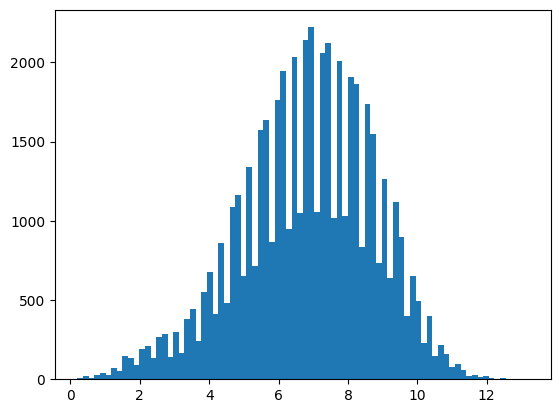

In [8]:
plt.hist(test,bins=80)

In [9]:
df_target = df_target.resample('d').mean()
df_reference = df_reference.resample('d').mean()


Text(0.5, 1.0, 'promedio diario IDEAM y ERA')

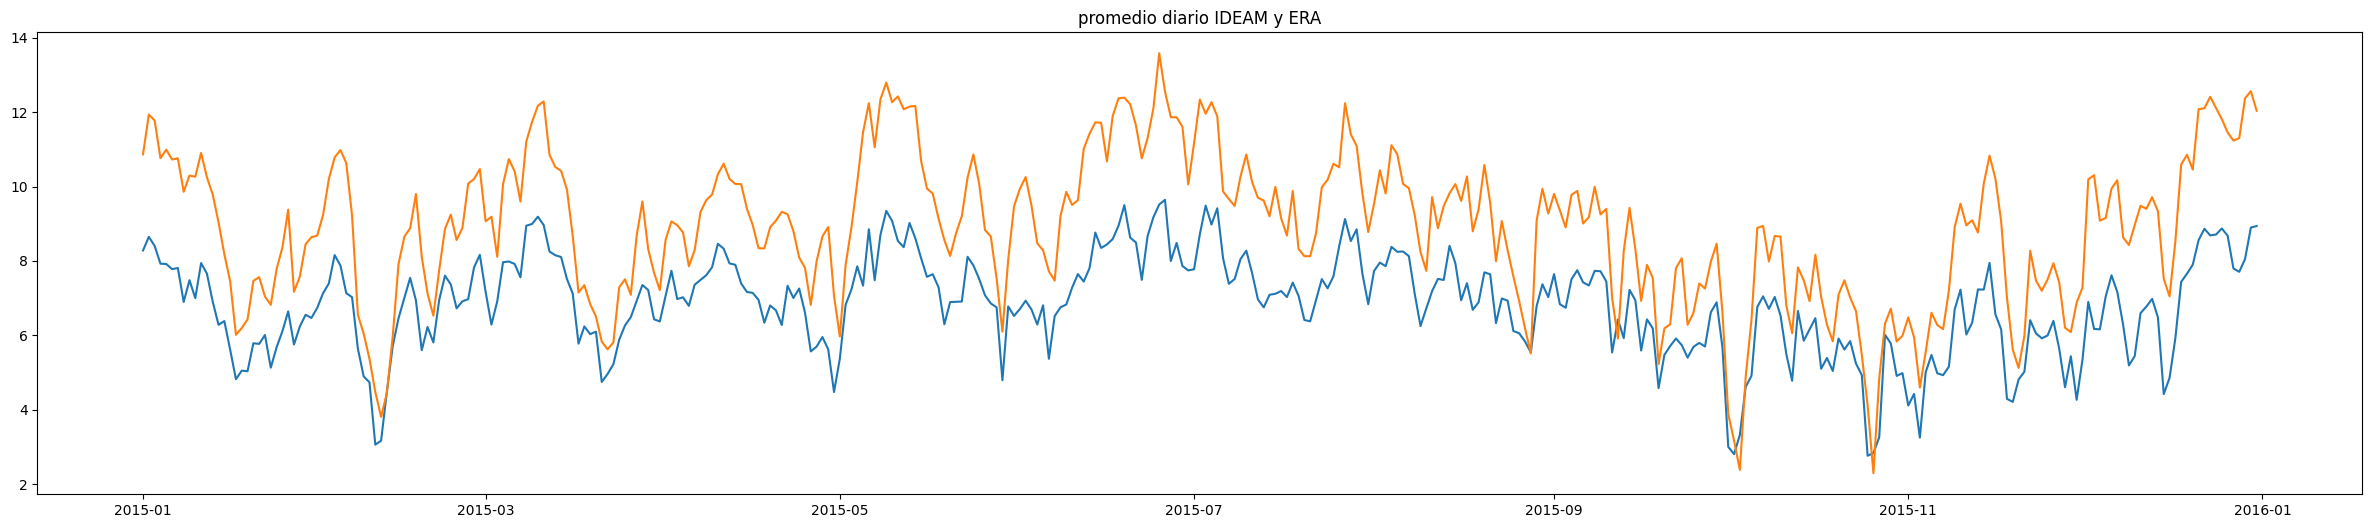

In [10]:
plt.figure(figsize=(30, 6))
plt.plot(df_target)
plt.plot(df_reference)
plt.title("promedio diario IDEAM y ERA")

Text(0.5, 1.0, 'promedio diario IDEAM y ERA datos escalados minmax')

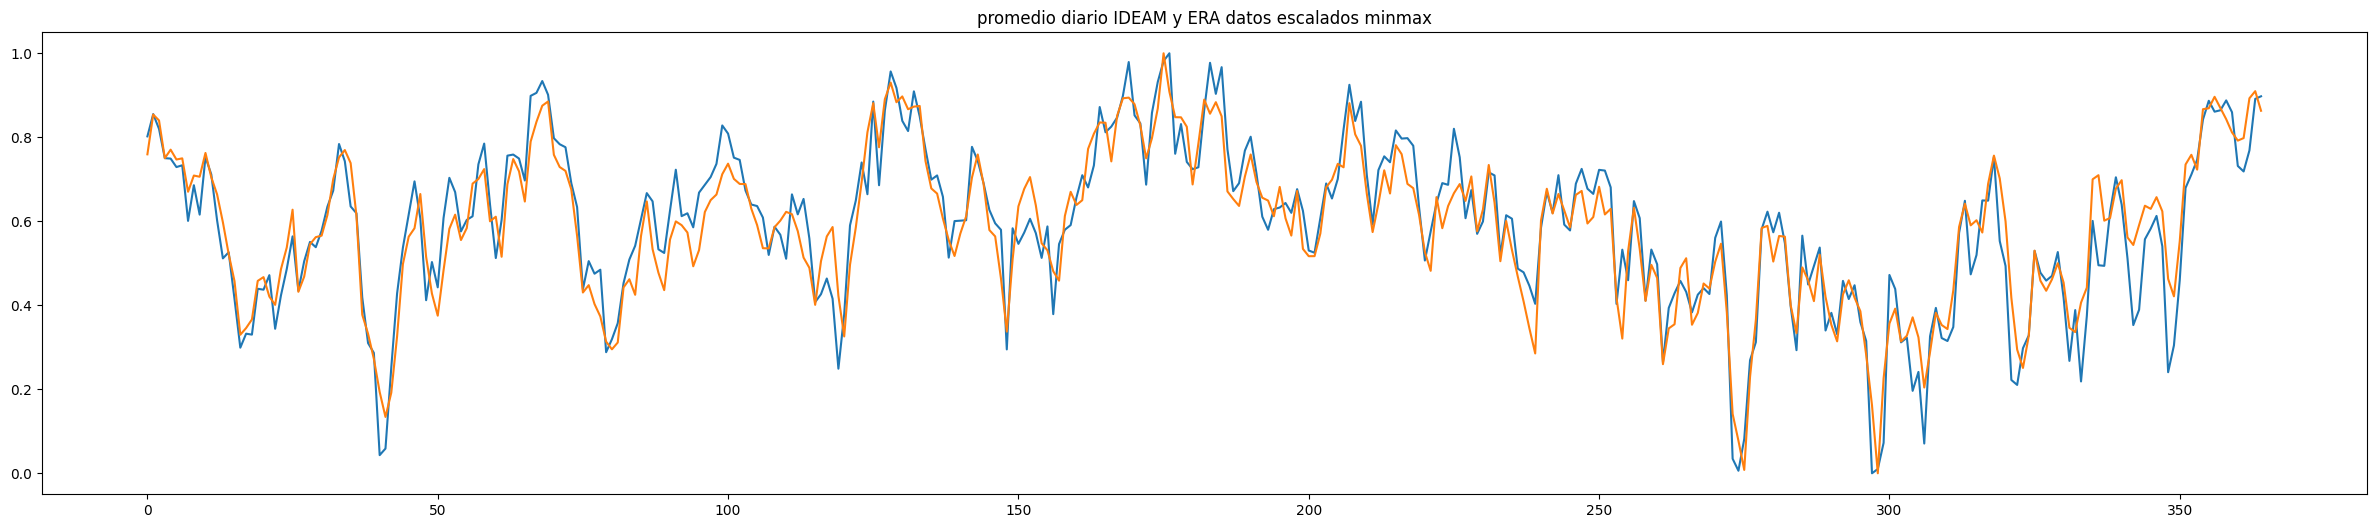

In [11]:
plt.figure(figsize=(30, 6))
plt.plot(minmax_scale(df_target))
plt.plot(minmax_scale(df_reference))
plt.title("promedio diario IDEAM y ERA datos escalados minmax")

In [14]:
# se convierten los datos en estructuras utiles para el entrenamiento de modelos
# además de utilizar escalarlos para tener una mejor regularizacion al
# usar Ridge y lasso

x_training = minmax_scale(df_reference)
y_training = minmax_scale(df_target)

In [15]:
from sklearn.linear_model import Ridge, LinearRegression,LassoCV

modelRidge = Ridge()
modelRidge.fit(x_training,y_training)
print("Ridge score:",modelRidge.score(x_training,y_training))

modelLinear = LinearRegression()
modelLinear.fit(x_training,y_training)
print("Linear score:",modelLinear.score(x_training,y_training))

modelLasso = LassoCV(alphas = [0.0001, 0.001,0.01, 0.1, 1, 10]).fit(x_training, y_training)
modelLasso.fit(x_training,y_training)
print("Lasso score:",modelLasso.score(x_training,y_training))

Ridge score: 0.864024603818065
Linear score: 0.8696101560756804
Lasso score: 0.869601516842061


/home/choclo/documents/MCP/env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1756: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/choclo/documents/MCP/env/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:1756: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


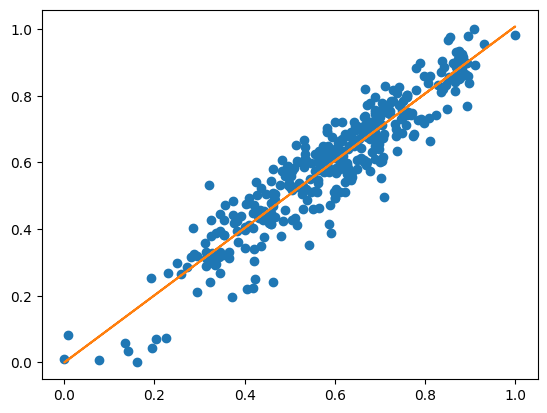

In [16]:
plt.scatter(x_training, y_training, label="Data Points")
plt.plot(x_training,modelLinear.predict(x_training),'C1')

Ahora nos encontramos con una problematica planteada en el articulo Reconstructing long‑term wind speed data based on measure correlate predict method for micro‑grid planning, donde se nos dice que este acercamiento a los datos puede tener un subajuste, además de plantearse la problemática de realizar este tipo de caracterizaciones teniendo estaciones con muy baja correlación. por esto mismo vamos a realizar la implementación de el articulo previamente mencionado.


<h3>Replicación paper: Reconstructing long‑term wind speed data based on measure 
correlate predict method for micro‑grid planning</h3>
se van a usar datos del 2011 de un aeropuerto de Colombia y los de Reanalisis del ERA

el plan de accion sería el siguiente:
<ol>
<li>se define año y coordenadas para la realización del MCP.</li>
<li>tener un data frame de referencia que cargamos con los métodos previamente planteados, los datos serían del ERA.</li>
<li>tener un data frame objetivo, este se crea a partir de los datos de las estaciones de IDEAM.</li>
<li>se realizan las tranformaciones necesarias de los datos para poder realizar una correlación entre ellos,</br> además de usarse en el CRP y al momento de entrenar modelos.</li>
<li>se realiza el metodo de CRP para confirmar la relación de los datos.</li>
<li>se realizan ls RBFNN para lograr una caracterización de la ubicación objetivo.</li>
<li>se realizan algoritmos geneticos para optimizar este método.</li>
<li>se plantea la experimentacion con otras redes: LSTM, RNN y demás métodos de forecasting.</li>
<li>se optimizan los métodos con mejores scores utilizando algoritmos genéticos y grid search.</li>

<h2>Pendientes</h2>
- revisar las correlaciones entre las variables disponibles: temperatura, presion, punto de rocio </br>
- terminar la replicación del articulo</br>
- revisar como implementar tsne</br>






</ol>

In [17]:
df = pd.read_csv('SKVP.csv')

In [18]:
df['valid'] = pd.to_datetime(df['valid'])

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8171 entries, 0 to 8170
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   station    8171 non-null   object        
 1   valid      8171 non-null   datetime64[ns]
 2   lon        8171 non-null   float64       
 3   lat        8171 non-null   float64       
 4   elevation  8171 non-null   float64       
 5   sped       8162 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 383.1+ KB


In [20]:
df = df.set_index('valid')

In [21]:
mask = (df['sped']>=df['sped'].quantile(0.01))& (df['sped']<=df['sped'].quantile(0.99))
df = df[mask]
df = df['sped'].resample('h').mean()

In [22]:
df

valid
2025-01-01 00:00:00    11.50
2025-01-01 01:00:00     9.20
2025-01-01 02:00:00     9.20
2025-01-01 03:00:00    10.35
2025-01-01 04:00:00     8.05
                       ...  
2025-12-08 19:00:00     5.75
2025-12-08 20:00:00     6.90
2025-12-08 21:00:00     4.60
2025-12-08 22:00:00     3.45
2025-12-08 23:00:00     4.60
Freq: h, Name: sped, Length: 8208, dtype: float64

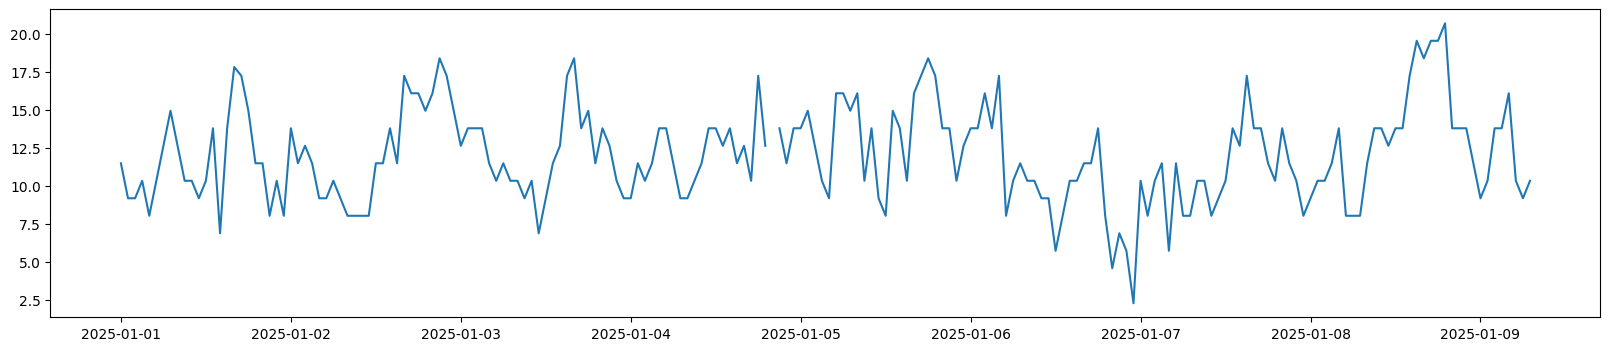

In [23]:

plt.figure(figsize=(20,4))
plt.plot(df[:200])